In [90]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
from venn import venn
import itertools

from scipy.stats import fisher_exact

In [25]:
def read_degenotate_mk(dir_path, file_name):
    
    ## Reads Degenotate MK table into a dict
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    df['standard_alpha'] = 1 - df['mk.odds.ni']
    mk_dict = df.set_index('gene').transpose().to_dict()
    return mk_dict

In [96]:
def compute_standard_MKT(p, p0, d, d0):
    
    ## calculates standard alpha and DoS
    try:
        standard_alpha = 1 - p / p0 * d0 / d
    except ZeroDivisionError:
        standard_alpha = 'NA'
    try:
        standard_dos = d / (d + d0) - p / (p + p0)
    except ZeroDivisionError:
        standard_dos = 'NA'
    return standard_alpha, standard_dos


def compute_extended_MKT(p, p0, d, d0, p_high, p0_high):
    
    ## calculates extended alpha and DoS
    try:
        ext_alpha = 1 - p_high / p0_high * d0 / d
    except ZeroDivisionError:
        ext_alpha = 'NA'
    try:
        ext_dos = d / (d + d0) - p_high / (p_high + p0_high)
    except ZeroDivisionError:
        ext_dos = 'NA'
    return ext_alpha, ext_dos


def compute_imputed_MKT(p, p0, d, d0, p_high, p0_high, p_low, p0_low):
    
    ## calculates imputed alpha and DoS
    try:
        p_wd = p_low - p_high / p0_high * p0_low
        imp_alpha = 1 - (p - p_wd) / p0 * d0 / d
    except ZeroDivisionError:
        imp_alpha = 'NA'
    try:
        p_wd = p_low - p_high / p0_high * p0_low
        imp_dos = d / (d + d0) - (p - p_wd) / ((p - p_wd) + p0)
        imp_odds, imp_pval = fisher_exact([[(p - p_wd), p0], [d, d0]])
    except ZeroDivisionError:
        imp_dos = 'NA'
        imp_pval = 'NA'
    return imp_alpha, imp_dos, imp_pval

In [101]:


def run_all_mkt(mk_dict, cutoff):
    
    ## Updates provided mk dictionary with MKT extension stats
    for g in mk_dict:
        try:
            pN_list = [float(i) for i in mk_dict[g]['af_nonsyn'].split('|')]
        except AttributeError:
            pN_list = []
        try:
            pS_list = [float(i) for i in mk_dict[g]['af_syn'].split('|')]
        except AttributeError:
            pS_list = []

        p  = len(pN_list)
        p0 = len(pS_list)
        d  = mk_dict[g]['dN']
        d0 = mk_dict[g]['dS']

        ## calculate standard alpha and DoS
        standard_alpha, standard_dos = compute_standard_MKT(p, p0, d, d0)

        ## calculate extended alpha and DoS
        pN_af_high = [i for i in pN_list if i > cutoff - .05]
        pS_af_high = [i for i in pS_list if i < cutoff - .05]
        p_high  = len(pN_af_high)
        p0_high = len(pN_af_high)
        ext_alpha, ext_dos = compute_extended_MKT(p, p0, d, d0, p_high, p0_high)

        ## calculate imputed alpha and DoS
        pN_af_high = [i for i in pN_list if i > cutoff]
        pN_af_low  = [i for i in pN_list if i < cutoff]
        pS_af_high = [i for i in pS_list if i > cutoff]
        pS_af_low  = [i for i in pS_list if i < cutoff]
        p_high  = len(pN_af_high)
        p0_high = len(pS_af_high)
        p_low   = len(pN_af_low)
        p0_low  = len(pS_af_low)
        print(g)
        imp_alpha, imp_dos, imp_pval = compute_imputed_MKT(p, p0, d, d0, p_high, p0_high, p_low, p0_low)

        ## update gene dictionary with new MKT statistics 
        mk_dict[g]['standard_alpha'] = standard_alpha
        mk_dict[g]['standard_dos'] = standard_dos
        mk_dict[g]['ext_alpha'] = ext_alpha
        mk_dict[g]['ext_dos'] = ext_dos
        mk_dict[g]['imp_alpha'] = imp_alpha
        mk_dict[g]['imp_dos'] = imp_dos
        mk_dict[g]['imp_pval'] = imp_pval
    return mk_dict

In [102]:
### Perform standard, extended, and imputed MKT

# dbs = ['vidMac', 'vidCha', 'indInd', 'anoImb', 'molAte', 'agePho', 'picPub']
dbs = ['vidMac', 'vidCha', 'indInd', 'anoImb']
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'

all_DFs = {}
i = 0
cutoff = 0.15

for db in dbs:
    ## Read data for each gene with syn/nonsyn AF
    print(db)
    file_name = 'MK_test_{}_ncbi/af.gene.longest.mk.tsv'.format(db)
    mk_dict = read_degenotate_mk(dir_path, file_name)
    all_DFs[db] = mk_dict
    
    ## Perform three MKT extensions
    mk_dict_extended = run_all_mkt(mk_dict, cutoff)
    
    ## Write an updated MKT dataframe into a file
    out_file = 'MK_test_{}_ncbi/extended.af.gene.longest.mk.tsv'.format(db)
    df_mkt = pd.DataFrame.from_dict(mk_dict_extended, orient='index')
    df_mkt.index.name = 'gene'
    df_mkt.to_csv(out_file, sep='\t')
    

vidMac
SMARCD3
[[0.0, 3], [0.0, 12.0]]
CHPF2
ABCF2
LOC128816626
ASB10
GBX1
AGAP3
[[0.0, 10], [5.0, 13.0]]
TMUB1
FASTK
SLC4A2
CDK5
ASIC3
ABCB8
ATG9B
NOS3
LOC128812376
KCNH2
AOC1
LOC128812500
LOC128812564
RARRES2
LRRC61
LOC128812663
TBRG4
NACAD
CCM2
PTPN23
SCAP
ELP6
CSPG5
SMARCC1
DHX30
MAP4
CDC25A
LOC128810109
ZNF777
LOC128812923
LOC128803948
LOC128803940
LOC128813000
LOC128813025
LOC128803964
LOC128803907
LOC128813070
LOC128813235
LOC128803897
LOC128803953
LOC128813354
CAMP
LOC128803993
KLHL18
KIF9
LOC128803974
SETD2
LOC128813594
LOC128817253
NBEAL2
CCDC12
PTH1R
MYL3
TMIE
ALS2CL
JMJD4
SNAP47
WNT9A
WNT3A
ARF1
C1H1orf35
MRPL55
GUK1
GJC2
IBA57
LOC128810690
OBSCN
[[115.072, 248], [49.0, 73.0]]
LOC128804748
[[12.5, 10], [7.0, 8.0]]
ACKR2
[[11.25, 9], [9.0, 12.0]]
HIGD1A
CCDC13
HHATL
[[2.2857142857142856, 16], [5.0, 3.0]]
KLHL40
[[2.2222222222222223, 20], [4.0, 14.0]]
ZBTB47
[[1.8888888888888893, 17], [0.0, 5.0]]
NKTR
[[3.4444444444444446, 31], [12.0, 18.0]]
SEC22C
VIPR1
LOC128817869
ADCYAP1R

LOC128803471
ZNF830
[[3.75, 5], [3.0, 11.0]]
BAG1
CHMP5
FH
SDHA
CCDC127
[[0.0, 5], [0.0, 1.0]]
SLC6A19
[[0.0, 7], [5.0, 9.0]]
LOC128808087
[[3.333333333333333, 5], [8.0, 11.0]]
TERT
CLPTM1L
LPCAT1
[[0.0, 4], [6.0, 6.0]]
MRPL36
NDUFS6
IRX4
IRX2
IRX1
ANKS6
GALNT12
LOC128815054
GABBR2
[[0.0, 12], [5.0, 9.0]]
ELP2
[[4.5, 9], [10.0, 7.0]]
CTNNAL1
[[4.5, 3], [1.0, 10.0]]
ABITRAM
SLC39A6
[[4.0, 8], [5.0, 19.0]]
TMEFF1
CAVIN4
[[1.5, 3], [1.0, 7.0]]
LOC128805918
[[29.842105263157897, 27], [13.0, 22.0]]
EXOC3
PDCD6
LOC128809267
[[9.0, 3], [24.0, 14.0]]
AHRR
MSANTD3
LOC128809668
TEX10
[[2.0, 8], [4.0, 8.0]]
INVS
[[4.666666666666666, 14], [0.0, 5.0]]
ERP44
STX17
[[2.0, 2], [0.0, 2.0]]
NR4A3
[[0.0, 2], [0.0, 11.0]]
SEC61B
ALG2
[[4.0, 8], [2.0, 5.0]]
LOC128814624
GLIPR2
LOC128807907
[[2.0, 2], [4.0, 6.0]]
PARD6G
[[0.0, 5], [0.0, 5.0]]
SCGN
CARMIL1
[[1.375, 11], [5.0, 22.0]]
RIPOR2
[[0.0, 11], [0.0, 8.0]]
GMNN
C1H6orf62
ACOT13
TDP2
[[3.0, 3], [6.0, 5.0]]
GALR1
[[2.0, 3], [4.0, 8.0]]
MBP
[[0.0, 3], [3

TASL
NR0B1
IL1RAPL1
[[2.5, 5], [0.0, 6.0]]
ARX
POLA1
[[6.0, 4], [13.0, 16.0]]
LOC128821376
PCYT1B
[[3.0, 3], [0.0, 5.0]]
PDK3
LOC128803613
[[0.0, 5], [3.0, 4.0]]
ZFX
EIF2S3
KLHL15
[[0.0, 5], [0.0, 7.0]]
APOO
SAT1
ACOT9
PRDX4
PTCHD1
[[4.0, 8], [1.0, 8.0]]
PHEX
[[0.0, 7], [8.0, 13.0]]
SMS
[[0.0, 4], [0.0, 1.0]]
MBTPS2
SMPX
KLHL34
[[3.0, 6], [3.0, 14.0]]
CNKSR2
[[6.666666666666666, 10], [0.0, 17.0]]
RPS6KA3
[[0.0, 2], [0.0, 14.0]]
EIF1AX
MAP7D2
BCLAF3
SH3KBP1
MAP3K15
[[12.0, 16], [0.0, 12.0]]
PDHA1
ADGRG2
[[9.333333333333332, 7], [19.0, 21.0]]
PHKA2
[[1.375, 11], [6.0, 22.0]]
PPEF1
[[1.0, 7], [7.0, 9.0]]
RS1
[[2.0, 4], [1.0, 1.0]]
CDKL5
[[3.5, 7], [1.0, 11.0]]
SCML2
RAI2
BEND2
NHS
REPS2
[[5.25, 7], [6.0, 10.0]]
RBBP7
[[0.0, 2], [0.0, 7.0]]
TXLNG
SYAP1
[[0.0, 3], [0.0, 6.0]]
CTPS2
[[4.714285714285714, 11], [3.0, 11.0]]
GRPR
AP1S2
[[0.0, 1], [3.0, 2.0]]
ZRSR2
CLTRN
[[1.0, 1], [3.0, 0.0]]
ACE2
[[0.0, 9], [11.0, 17.0]]
VEGFD
PIGA
ASB11
ASB9
[[2.0, 2], [6.0, 7.0]]
MOSPD2
[[0.0, 5], [2.0, 6.0]]

NOX4
[[0.0, 5], [0.0, 6.0]]
LOC128804045
[[2.6666666666666665, 8], [4.0, 11.0]]
LOC128803031
[[1.4285714285714288, 10], [11.0, 15.0]]
CHORDC1
FAT3
[[4.4, 44], [22.0, 109.0]]
MTNR1B
SLC36A4
[[0.0, 1], [6.0, 10.0]]
DEUP1
CEP295
[[14.875, 17], [15.0, 10.0]]
TAF1D
C2H11orf54
[[0.0, 2], [0.0, 6.0]]
MED17
[[0.0, 9], [1.0, 8.0]]
VSTM5
LOC128803794
[[3.6, 9], [10.0, 13.0]]
LOC128803448
[[0.0, 2], [1.0, 2.0]]
HEPHL1
PANX1
GPR83
[[1.75, 7], [6.0, 10.0]]
MRE11
[[1.5999999999999996, 8], [5.5, 9.5]]
ANKRD49
C2H11orf97
[[0.0, 2], [2.0, 2.0]]
FUT4
AMOTL1
[[6.333333333333333, 19], [6.0, 22.0]]
CWC15
[[0.0, 3], [0.0, 6.0]]
ENDOD1
[[1.3333333333333333, 4], [9.0, 18.0]]
SESN3
[[0.0, 4], [2.0, 10.0]]
FAM76B
[[0.0, 4], [0.0, 6.0]]
CEP57
MTMR2
MAML2
[[0.0, 7], [6.0, 17.0]]
CCDC82
[[3.333333333333333, 5], [14.0, 15.0]]
CNTN5
[[6.666666666666666, 10], [5.5, 15.5]]
ARHGAP42
[[0.0, 5], [3.0, 13.0]]
PGR
TRPC6
[[0.0, 10], [1.0, 14.0]]
ANGPTL5
CEP126
[[18.0, 6], [49.5, 17.5]]
CFAP300
YAP1
LOC128803223
TMEM123
LOC1

PLEKHH2
[[7.333333333333333, 11], [8.0, 24.0]]
DYNC2LI1
ABCG5
[[0.0, 4], [14.0, 12.0]]
ABCG8
LRPPRC
[[12.0, 6], [31.0, 29.0]]
PPM1B
SLC3A1
[[9.0, 3], [8.0, 17.0]]
PREPL
[[9.0, 6], [17.0, 11.0]]
CAMKMT
SIX3
SIX2
SRBD1
[[0.0, 13], [10.0, 23.0]]
PRKCE
[[0.0, 7], [0.0, 9.0]]
EPAS1
[[0.0, 2], [9.0, 15.0]]
RHOQ
PIGF
CRIPT
[[0.0, 5], [0.0, 4.0]]
CAPN2
TP53BP2
[[3.8, 19], [0.0, 2.0]]
FBXO28
[[0.0, 5], [0.0, 2.0]]
DEGS1
NVL
CNIH4
WDR26
CNIH3
[[0.0, 2], [0.0, 2.0]]
LBR
ENAH
[[0.0, 6], [0.0, 7.0]]
SRP9
EPHX1
TMEM63A
[[3.0, 3], [6.0, 17.0]]
LOC128805130
SDE2
LOC128804932
LOC128805400
ACBD3
[[0.0, 7], [9.5, 0.5]]
MIXL1
LIN9
[[0.0, 2], [2.0, 8.0]]
PARP1
STUM
ITPKB
[[4.5, 3], [9.0, 15.0]]
PSEN2
[[0.0, 11], [5.0, 15.0]]
COQ8A
[[0.0, 7], [7.0, 16.0]]
CDC42BPA
[[0.0, 18], [3.0, 34.0]]
XDH
[[3.5999999999999996, 9], [9.0, 28.0]]
LOC128804831
EHD3
[[0.0, 7], [0.0, 10.0]]
CAPN14
[[6.0, 3], [6.0, 9.0]]
GALNT14
[[0.0, 8], [2.0, 10.0]]
CAPN13
[[3.4285714285714284, 8], [30.5, 10.5]]
LOC128804746
SRF
PTK7
LOC128

LOC128805574
COL21A1
[[10.666666666666666, 16], [5.0, 9.0]]
BMP5
[[0.0, 3], [0.0, 6.0]]
LOC128804958
HMGCLL1
[[1.2, 6], [0.0, 1.0]]
GFRAL
[[12.0, 3], [13.5, 11.5]]
HCRTR2
[[0.0, 2], [6.0, 9.0]]
FAM83B
[[3.5454545454545454, 13], [16.0, 17.0]]
TINAG
MLIP
[[12.0, 2], [31.5, 20.5]]
LRRC1
[[0.0, 3], [1.0, 2.0]]
LOC128805212
KLHL31
[[0.0, 8], [3.0, 12.0]]
GCLC
[[0.0, 9], [0.0, 4.0]]
ELOVL5
GCM1
FBXO9
CILK1
LOC128804704
LOC128804706
LOC128804707
LOC128804705
TMEM14A
AGPAT5
[[0.0, 2], [1.0, 3.0]]
MCPH1
[[4.0, 8], [30.0, 10.0]]
ANGPT2
[[0.0, 4], [1.0, 5.0]]
CSMD1
[[3.5384615384615383, 23], [0.0, 8.0]]
MYOM2
[[1.125, 9], [9.0, 23.0]]
KBTBD11
[[0.0, 11], [2.0, 10.0]]
ARHGEF10
[[4.571428571428571, 16], [15.0, 27.0]]
CLN8
DLGAP2
[[0.0, 6], [0.0, 20.0]]
ERICH1
TDRP
FBXO25
FAM110C
SH3YL1
[[4.0, 4], [1.0, 3.0]]
ACP1
ALKAL2
TMEM18
SNTG2
[[0.0, 1], [1.0, 2.0]]
TPO
[[5.909090909090909, 13], [5.0, 8.0]]
PXDN
[[1.25, 20], [4.0, 26.0]]
MYT1L
[[0.0, 3], [0.0, 3.0]]
EIPR1
[[0.0, 2], [1.0, 2.0]]
TRAPPC12
[[2.0

EXOC1
[[3.5, 7], [0.0, 14.0]]
EXOC1L
NMU
PDCL2
CLOCK
[[2.0, 6], [3.0, 13.0]]
TMEM165
[[0.0, 6], [0.0, 5.0]]
SRD5A3
KDR
[[1.6666666666666665, 15], [13.0, 40.0]]
KIT
[[0.0, 11], [8.0, 15.0]]
PDGFRA
[[1.25, 10], [2.0, 26.0]]
GSX2
CHIC2
LNX1
FIP1L1
[[0.0, 3], [1.0, 10.0]]
SCFD2
[[1.1428571428571432, 8], [9.0, 6.0]]
RASL11B
[[0.0, 3], [1.0, 0.0]]
USP46
SPATA18
[[6.0, 6], [40.0, 17.0]]
SGCB
[[0.0, 5], [0.0, 5.0]]
LRRC66
[[72.0, 9], [43.5, 26.5]]
DCUN1D4
CWH43
[[7.0, 7], [10.0, 15.0]]
OCIAD2
OCIAD1
[[0.0, 2], [2.0, 0.0]]
FRYL
[[2.0, 20], [6.0, 35.0]]
ZAR1
SLC10A4
SLAIN2
[[9.0, 9], [0.0, 11.0]]
TEC
[[2.0, 4], [0.0, 14.0]]
TXK
[[2.4000000000000004, 12], [14.0, 14.0]]
NIPAL1
CNGA1
NFXL1
[[4.666666666666666, 7], [3.0, 21.0]]
CORIN
[[6.5, 13], [14.0, 20.0]]
ATP10D
[[18.0, 3], [27.5, 19.5]]
COMMD8
GABRB1
GABRA4
[[0.0, 3], [1.0, 4.0]]
GABRA2
[[0.0, 3], [0.0, 2.0]]
GABRG1
[[0.0, 4], [0.0, 1.0]]
GNPDA2
GUF1
YIPF7
KCTD8
[[2.0, 4], [0.0, 3.0]]
GRXCR1
LOC128806251
ATP8A1
[[2.333333333333333, 7], [0.0, 4.

ASCL1
PAH
[[0.0, 3], [1.0, 13.0]]
PARPBP
[[6.666666666666666, 5], [14.5, 16.5]]
LOC128807259
[[2.8, 7], [10.0, 5.0]]
IGF1
PMCH
NUP37
[[2.6666666666666665, 4], [5.0, 4.0]]
WASHC3
[[1.0, 1], [1.0, 3.0]]
DRAM1
[[0.0, 2], [3.0, 6.0]]
GNPTAB
[[1.6666666666666665, 10], [13.0, 32.0]]
SYCP3
CHPT1
[[1.0, 2], [2.0, 7.0]]
MYBPC1
[[0.0, 9], [1.0, 4.0]]
SPIC
LOC128807635
[[4.666666666666666, 7], [9.0, 11.0]]
TBXAS1
[[1.75, 7], [6.0, 14.0]]
HIPK2
[[2.333333333333333, 7], [1.0, 23.0]]
KIAA1549
[[7.8125, 25], [35.0, 43.0]]
TMEM213
ATP6V0A4
[[2.6666666666666665, 4], [0.0, 13.0]]
SVOPL
[[0.0, 6], [5.0, 15.0]]
TMTC1
[[3.333333333333334, 5], [3.0, 19.0]]
IPO8
[[0.0, 10], [4.0, 23.0]]
CAPRIN2
[[0.0, 11], [15.0, 9.0]]
SINHCAF
DENND5B
[[0.0, 16], [1.0, 29.0]]
AMN1
ETFBKMT
RESF1
[[64.0, 16], [53.0, 40.0]]
LOC128807822
BICD1
[[0.0, 18], [1.0, 19.0]]
FGD4
[[0.0, 2], [16.0, 23.0]]
DNM1L
YARS2
PKP2
[[8.88888888888889, 16], [9.0, 13.0]]
SYT10
[[1.5714285714285714, 11], [2.0, 18.0]]
STMP1
SLC13A4
[[3.0, 2], [5.0, 1

STON2
[[0.0, 12], [8.0, 18.0]]
GTF2A1
TSHR
CEP128
[[10.4, 13], [20.0, 25.0]]
DIO2
NRXN3
[[0.0, 12], [2.0, 25.0]]
ADCK1
[[2.25, 9], [8.0, 9.0]]
SNW1
[[0.0, 2], [0.0, 15.0]]
SLIRP
[[0.0, 1], [4.0, 5.0]]
ALKBH1
SPTLC2
[[0.0, 2], [0.0, 6.0]]
ISM2
AHSA1
VIPAS39
NOXRED1
SAMD15
TMED8
LOC128808554
[[0.0, 8], [8.0, 8.0]]
GSTZ1
[[1.0, 3], [1.0, 3.0]]
POMT2
[[1.5, 6], [1.0, 8.0]]
NGB
TMEM63C
[[0.0, 12], [3.0, 21.0]]
ZDHHC22
CIPC
IRF2BPL
ANGEL1
VASH1
ESRRB
[[0.0, 4], [2.0, 4.0]]
GPATCH2L
[[0.0, 3], [7.0, 8.0]]
IFT43
[[0.0, 2], [5.0, 5.0]]
TGFB3
[[1.6666666666666665, 5], [1.0, 6.0]]
TTLL5
[[12.0, 12], [42.5, 28.5]]
ERG28
[[0.0, 4], [0.0, 3.0]]
FLVCR2
[[2.0, 4], [6.0, 5.0]]
BATF
JDP2
[[0.0, 4], [0.0, 1.0]]
FOS
[[0.0, 2], [0.0, 3.0]]
TMED10
NEK9
ZC2HC1C
ACYP1
MLH3
EIF2B2
PGF
RPS6KL1
DLST
[[0.0, 2], [0.0, 4.0]]
PROX2
[[17.5, 5], [12.0, 9.0]]
YLPM1
[[3.1111111111111107, 19], [16.0, 41.0]]
FCF1
AREL1
[[0.0, 2], [4.0, 12.0]]
LTBP2
[[3.642857142857143, 17], [18.0, 47.0]]
NPC2
[[1.0, 2], [1.0, 0.0]]
ISCA2


C7H21orf58
KMO
ITGB2
SLX9
ADARB1
[[1.375, 11], [1.0, 14.0]]
ZNF804A
[[14.615384615384617, 19], [24.0, 22.0]]
ZC3H15
ITGAV
[[0.0, 15], [3.0, 23.0]]
FAM171B
[[5.333333333333333, 16], [9.0, 17.0]]
CALCRL
[[0.0, 10], [1.0, 5.0]]
TFPI
[[10.0, 10], [13.0, 9.0]]
GULP1
[[0.0, 6], [0.0, 3.0]]
COL3A1
[[0.0, 36], [1.0, 19.0]]
COL5A2
[[1.8888888888888893, 34], [1.0, 15.0]]
SLC40A1
[[0.0, 6], [4.0, 8.0]]
WDR75
[[1.666666666666667, 15], [8.0, 14.0]]
ASDURF
ASNSD1
[[13.5, 9], [9.0, 15.0]]
OSGEPL1
[[0.0, 12], [4.0, 13.0]]
ORMDL1
[[0.0, 2], [0.0, 1.0]]
PMS1
[[6.75, 9], [19.0, 12.0]]
MSTN
[[0.0, 6], [0.0, 5.0]]
C7H2orf88
[[0.0, 4], [1.0, 0.0]]
HIBCH
[[3.333333333333333, 5], [5.0, 7.0]]
MFSD6
[[11.0, 11], [4.0, 11.0]]
NEMP2
[[0.0, 5], [8.0, 6.0]]
NAB1
[[0.0, 9], [3.0, 6.0]]
GLS
[[0.0, 12], [0.0, 10.0]]
STAT1
[[4.0, 12], [7.0, 19.0]]
STAT4
[[0.0, 6], [0.0, 12.0]]
MYO1B
[[0.0, 10], [4.0, 13.0]]
TSSK6
NABP1
[[1.5, 3], [1.0, 2.0]]
CAVIN2
[[4.666666666666666, 7], [3.0, 6.0]]
TMEFF2
SLC39A10
LOC128810067
STK17

ITPRIP
[[2.6666666666666665, 8], [3.0, 8.0]]
GSTO1
CFAP43
[[8.0, 10], [42.0, 28.0]]
SFR1
[[3.0, 2], [3.0, 4.0]]
COL17A1
[[2.0, 4], [12.0, 24.0]]
SLK
[[11.666666666666668, 7], [14.0, 15.0]]
STN1
[[0.0, 4], [3.0, 5.0]]
SH3PXD2A
NEURL1
[[0.0, 11], [2.0, 12.0]]
CALHM3
CALHM1
[[0.0, 6], [3.0, 4.0]]
CALHM2
[[0.0, 7], [0.0, 8.0]]
PDCD11
[[13.0, 13], [24.0, 49.0]]
ATP5MK
TAF5
[[2.0, 4], [0.0, 15.0]]
PCGF6
INA
NT5C2
CNNM2
[[0.0, 9], [1.0, 8.0]]
AS3MT
[[1.5, 3], [7.0, 8.0]]
BORCS7
LOC128810585
[[0.0, 6], [1.0, 8.0]]
WBP1L
[[0.0, 3], [3.0, 9.0]]
SFXN2
ARL3
TRIM8
[[0.0, 9], [0.0, 9.0]]
SUFU
[[0.0, 5], [0.0, 14.0]]
ACTR1A
MFSD13A
[[0.0, 4], [2.0, 11.0]]
C8H10orf95
SLF2
[[18.333333333333336, 11], [44.5, 20.5]]
SEMA4G
MRPL43
TWNK
LOC128810617
PDZD7
KAZALD1
TLX1
LBX1
[[0.0, 3], [0.0, 3.0]]
BTRC
LOC128810853
[[3.6, 9], [8.0, 11.0]]
POLL
[[1.6, 8], [7.0, 15.0]]
DPCD
FBXW4
FGF8
NPM3
OGA
KCNIP2
ARMH3
[[0.0, 5], [6.0, 13.0]]
HPS6
[[13.5, 9], [14.0, 15.0]]
LOC128810464
[[6.0, 12], [24.0, 16.0]]
LDB1
PPRC1
[

MCOLN2
[[2.333333333333333, 7], [2.0, 18.0]]
LPAR3
[[0.0, 4], [0.0, 1.0]]
SSX2IP
[[0.0, 2], [7.0, 9.0]]
LOC128811394
[[9.75, 26], [36.0, 42.0]]
LOC128811498
[[21.818181818181817, 20], [42.0, 31.0]]
CTBS
SPATA1
GNG5
[[0.0, 1], [0.0, 2.0]]
RPF1
DNASE2B
[[0.0, 4], [7.0, 10.0]]
LOC128811217
SAMD13
PRKACB
TTLL7
[[2.5, 5], [7.0, 13.0]]
ADGRL2
[[2.0, 12], [1.0, 22.0]]
ADGRL4
[[0.0, 3], [3.0, 10.0]]
LOC128811625
[[18.285714285714285, 16], [32.5, 42.5]]
PTGFR
[[0.0, 2], [1.0, 5.0]]
GIPC2
[[12.0, 4], [1.0, 5.0]]
DNAJB4
FUBP1
NEXN
MIGA1
USP33
ZZZ3
[[4.0, 4], [3.0, 11.0]]
AK5
[[3.0, 9], [5.0, 11.0]]
PIGK
[[0.0, 4], [3.0, 6.0]]
ST6GALNAC5
[[0.0, 2], [3.0, 5.0]]
ST6GALNAC3
[[3.0, 3], [2.0, 4.0]]
PIF1
CFAP144
EBNA1BP2
CFAP57
[[15.583333333333332, 17], [24.0, 20.0]]
TMEM125
C9H1orf210
[[4.0, 4], [11.0, 8.0]]
TIE1
[[0.0, 19], [5.0, 35.0]]
MPL
CDC20
[[0.0, 3], [3.0, 11.0]]
ELOVL1
[[0.0, 3], [0.0, 2.0]]
MED8
[[0.0, 5], [1.0, 2.0]]
SZT2
[[5.307692307692308, 23], [13.5, 72.5]]
LOC128811799
[[0.0, 4], [2.0,

NEU2
NGEF
[[3.6, 9], [5.0, 9.0]]
SNORC
[[0.0, 4], [1.0, 2.0]]
GIGYF2
[[3.75, 10], [2.0, 10.0]]
KCNJ13
[[2.8, 7], [1.0, 9.0]]
EFHD1
AIRE
LOC128812075
SCLY
SLC35G2
STAG1
[[0.0, 13], [0.0, 12.0]]
PCCB
[[0.0, 10], [1.0, 12.0]]
MSL2
[[0.0, 4], [1.0, 7.0]]
PPP2R3A
[[12.0, 3], [14.0, 20.0]]
DBR1
[[0.0, 7], [1.0, 6.0]]
ARMC8
[[0.0, 2], [1.0, 10.0]]
NME9
[[2.0, 3], [4.0, 5.0]]
VPS8
[[15.0, 10], [5.0, 35.0]]
C10H3orf70
[[0.0, 5], [3.5, 1.5]]
EHHADH
[[13.2, 11], [13.0, 7.0]]
MAP3K13
[[2.111111111111111, 19], [7.0, 12.0]]
TMEM41A
LIPH
[[1.5, 12], [5.0, 3.0]]
ANAPC13
CEP63
[[2.666666666666667, 8], [8.0, 15.0]]
KY
[[3.333333333333333, 10], [9.0, 9.0]]
EPHB1
A4GNT
CLDN18
[[0.0, 14], [1.0, 3.0]]
SOX14
CRYGS
[[0.0, 5], [1.0, 2.0]]
TBCCD1
[[2.333333333333333, 7], [1.0, 3.0]]
DNAJB11
PROCR
PFKL
CFAP410
TRA2B
IGF2BP2
SENP2
AMOTL2
RYK
[[0.0, 8], [1.0, 7.0]]
SLCO2A1
LOC128811890
LOC128811891
[[3.0, 9], [18.0, 7.0]]
LOC128811892
[[2.666666666666666, 8], [20.0, 12.0]]
PAK2
[[0.0, 8], [0.0, 5.0]]
PIGX
CEP19
NR

PATL2
SNX1
SNX22
PPIB
CSNK1G1
PCLAF
TRIP4
ZNF609
[[0.0, 5], [7.0, 38.0]]
OAZ2
RBPMS2
SORD
DUOX2
DUOXA2
LOC128813401
NMB
SEC11A
ZNF592
LOC128813602
ALPK3
LOC128813286
LOC128813638
RAB8B
[[0.0, 1], [0.0, 3.0]]
RPS27L
LACTB
[[0.0, 1], [9.0, 10.0]]
TPM1
TLN2
[[0.0, 8], [4.0, 69.0]]
LOC128813454
LOC128813501
VPS13C
[[8.0, 8], [27.5, 48.5]]
LOC128813635
[[0.0, 3], [2.0, 7.0]]
ICE2
[[1.75, 7], [18.0, 20.0]]
ANXA2
FOXB1
BNIP2
GTF2A2
GCNT3
OTUD7A
[[0.0, 10], [3.0, 18.0]]
KLF13
TRPM1
[[3.0, 18], [7.0, 21.0]]
MTMR10
[[3.0, 3], [7.0, 21.0]]
FAN1
[[8.0, 2], [21.0, 18.0]]
MCEE
MPHOSPH10
APBA2
[[2.0, 7], [3.0, 16.0]]
ENTREP2
[[4.0, 4], [7.0, 6.0]]
TJP1
[[0.0, 16], [5.0, 34.0]]
LOC128813516
TM2D3
ADAL
[[0.0, 1], [1.0, 8.0]]
LARP6
LRRC49
[[2.0, 2], [5.0, 11.0]]
THSD4
[[9.333333333333332, 14], [1.0, 16.0]]
LOC128813355
[[0.0, 9], [0.0, 1.0]]
FAM81A
[[0.0, 4], [1.0, 5.0]]
MYO1E
CCNB2
[[0.0, 3], [3.0, 7.0]]
RNF111
[[2.2, 11], [2.0, 12.0]]
SLTM
[[0.0, 6], [6.0, 13.0]]
MINDY2
[[0.0, 2], [1.0, 5.0]]
ADAM10
[

MPP1
[[0.0, 7], [3.0, 10.0]]
DKC1
[[0.0, 11], [5.0, 11.0]]
F8A1
TRMT2B
TMEM35A
CENPI
[[7.2, 6], [27.0, 13.0]]
DRP2
[[9.333333333333332, 14], [0.0, 2.0]]
LOC128814557
TAF7L
LOC128814341
TIMM8A
BTK
RPL36A
GLA
LOC128814332
PLP1
RAB9B
LOC128814349
PRPS1
FRMPD3
DNAAF6
LOC128814331
RBM41
LOC128814330
CLDN2
RIPPLY1
PRRG3
LOC128814340
LOC128814329
LOC128814334
LOC128814333
GABRA3
LOC128814355
LOC128814433
LOC128814246
CAPN6
[[8.75, 7], [6.0, 13.0]]
DCX
SERTM2
[[0.0, 3], [0.0, 1.0]]
LOC128814496
LOC128814494
[[7.0, 7], [16.0, 10.0]]
TRPC5
[[0.0, 12], [0.0, 17.0]]
AMOT
[[0.0, 10], [0.0, 11.0]]
PGK1
[[0.0, 5], [3.0, 11.0]]
ATP7A
[[11.428571428571427, 20], [9.0, 19.0]]
LOC128814266
MAGT1
ATRX
[[10.0, 20], [24.0, 44.0]]
FGF16
ZDHHC15
UPRT
ABCB7
[[6.0, 2], [5.0, 12.0]]
NEXMIF
[[6.75, 18], [9.0, 33.0]]
RLIM
SLC16A2
LOC128814302
LOC128814304
LOC128814303
[[0.0, 2], [0.0, 4.0]]
LOC128814386
[[0.0, 5], [1.0, 4.0]]
LOC128814544
[[0.0, 4], [3.0, 16.0]]
LOC128814533
[[0.0, 2], [3.0, 10.0]]
CHIC1
[[0.0, 1],

NUDT1
SNX8
[[0.0, 9], [1.0, 9.0]]
LOC128815390
EIF3B
CHST12
LOC128815386
GRIFIN
LFNG
[[0.0, 5], [1.0, 5.0]]
TTYH3
[[0.0, 5], [1.0, 5.0]]
IQCE
[[8.4, 7], [29.0, 15.0]]
BRAT1
[[8.0, 8], [12.0, 20.0]]
AMZ1
GNA12
[[0.0, 4], [0.0, 2.0]]
CARD11
[[6.571428571428571, 23], [9.0, 19.0]]
SDK1
[[18.0, 39], [9.5, 37.5]]
LOC128815582
[[2.0, 4], [1.0, 5.0]]
LOC128815609
[[0.0, 13], [7.0, 9.0]]
FOXK1
[[0.0, 7], [1.0, 7.0]]
AP5Z1
[[15.0, 5], [13.0, 17.0]]
RADIL
[[15.5, 31], [0.0, 7.0]]
MMD2
WIPI2
SLC29A4
[[0.0, 12], [2.0, 16.0]]
TNRC18
FBXL18
ACTB
FSCN1
[[0.0, 3], [0.0, 6.0]]
RNF216
[[7.2, 9], [14.0, 13.0]]
SMURF1
KPNA7
ARPC1A
ARPC1B
PDAP1
BUD31
[[0.0, 2], [0.0, 3.0]]
PTCD1
[[12.0, 12], [6.0, 11.0]]
CPSF4
[[0.0, 2], [2.0, 7.0]]
ATP5MF
[[0.0, 3], [3.0, 2.0]]
LOC128815599
[[0.0, 3], [0.0, 6.0]]
MAP2K3
NATD1
TMEM11
DHRS7B
LOC128815565
USP22
TNFRSF13B
[[0.0, 4], [1.0, 1.0]]
MPRIP
[[8.653846153846153, 45], [10.0, 37.0]]
PLD6
[[0.0, 2], [1.0, 0.0]]
FLCN
[[2.0, 6], [0.0, 7.0]]
COPS3
NT5M
MED9
RASD1
PEMT
[[0.0

AXIN2
[[21.0, 7], [0.0, 2.0]]
LOC128816995
LOC128816994
GNA13
SLC16A6
ARSG
WIPI1
PRKAR1A
FAM20A
LOC128816842
LOC128816819
LOC128816764
ABCA5
MAP2K6
KCNJ16
KCNJ2
SOX9
SLC39A11
SSTR2
COG1
FAM104A
C19H17orf80
CPSF4L
CDC42EP4
SDK2
RPL38
TTYH2
DNAI2
BTBD17
GPR142
GPRC5C
CCDC137
OXLD1
PDE6G
TSPAN10
NPLOC4
LOC128816866
FAAP100
FSCN2
ACTG1
BAHCC1
SLC38A10
NDUFAF8
TEPSIN
CEP131
AATK
BAIAP2
CHMP6
RPTOR
NPTX1
ENDOV
RNF213
SLC26A11
SGSH
GAA
CCDC40
TBC1D16
CBX4
LOC128817027
CBX8
LOC128816706
RBFOX3
ENGASE
C1QTNF1
CANT1
TIMP2
USP36
CYTH1
DNAH17
PGS1
SOCS3
LOC128816948
AFMID
TK1
SYNGR2
TMC6
ARL16
HGS
MRPL12
SLC25A10
GCGR
MCRIP1
PPP1R27
P4HB
ARHGDIA
ALYREF
ANAPC11
LOC128816617
MAFG
PYCR1
MYADML2
NOTUM
ASPSCR1
[[3.0, 3], [5.0, 11.0]]
CENPX
LRRC45
[[0.0, 4], [5.0, 10.0]]
RAC3
DCXR
[[0.0, 2], [2.0, 10.0]]
RFNG
[[0.0, 3], [2.0, 4.0]]
GPS1
[[0.0, 3], [1.0, 10.0]]
DUS1L
FASN
[[5.0, 2], [42.0, 49.0]]
CCDC57
[[0.0, 2], [16.0, 4.0]]
SLC16A3
CSNK1D
LOC128817234
BCL7B
TBL2
MLXIPL
LOC128817273
BAZ1B
FZD9
FKBP6
NS

SERINC2
LOC128819013
FABP3
ZCCHC17
SNRNP40
NKAIN1
PUM1
SDC3
LAPTM5
MATN1
PTPRU
MECR
SRSF4
LOC128818965
TMEM200B
[[3.6666666666666665, 11], [15.0, 19.0]]
EPB41
LOC128818911
TRNAU1AP
LOC128819150
LOC128819011
TAF12
LOC128818882
GMEB1
YTHDF2
LOC128819287
LOC128819285
KLHL33
NDUFA11
RANBP3
LOC128819258
LONP1
RPL36
LMNB2
TIMM13
TMPRSS9
SPPL2B
LSM7
LOC128819472
CERS4
LOC128819522
LOC128819475
MARCHF2
RAB11B
ANGPTL4
KANK3
RPS28
NDUFA7
CD320
LOC128819451
LOC128819439
LOC128819523
POLE4
LOC128819482
[[6.0, 3], [4.0, 6.0]]
LOC128819445
[[0.0, 4], [1.0, 13.0]]
ELAVL1
MATK
LOC128819481
RAX2
LOC128819228
MRPL54
APBA3
TJP3
PIP5K1C
[[0.0, 2], [3.0, 19.0]]
CACTIN
TBXA2R
GIPC3
HMG20B
MFSD12
LOC128819273
FZR1
LOC128819509
DOHH
SMIM44
SMIM24
NFIC
UNC13A
MEX3D
MBD3
LOC128819435
TCF3
ONECUT3
ATP8B3
REXO1
ABHD17A
LOC128819529
LOC128819233
LOC128819444
SCAMP4
CSNK1G2
BTBD2
MKNK2
LOC128819503
MOB3A
AP3D1
DOT1L
[[2.8000000000000007, 14], [0.0, 1.0]]
PLEKHJ1
SF3A2
AMH
LOC128819530
OAZ1
PEAK3
LINGO3
LOC128819457

LOC128821101
[[0.0, 11], [2.0, 10.0]]
LOC128821059
[[0.0, 5], [6.0, 22.0]]
LOC128821057
LOC128821064
LOC128821060
LOC128821100
LOC128821067
LOC128821066
LOC128821068
KRT8
KRT18
EIF4B
TNS2
SPRYD3
MFSD5
RARG
ZNF740
CSAD
LOC128821074
GPN1
ZNF512
FNDC4
[[0.0, 5], [0.0, 2.0]]
LOC128821149
IFT172
[[4.846153846153847, 21], [10.5, 42.5]]
KRTCAP3
NRBP1
PPM1G
LOC128821182
ZNF513
SNX17
EIF2B4
GTF3C2
SLC30A3
LOC128821170
DNAJC5G
TRIM54
UCN
MPV17
CAD
ATRAID
SLC5A6
PREB
CGREF1
KHK
LOC128821163
EMILIN1
OST4
AGBL5
TMEM214
LOC128821142
LOC128821137
DPYSL5
DNMT3A
DTNB
ASXL2
KIF3C
LOC128821143
RAB10
GAREM2
HADHA
HADHB
LOC128821169
LOC128821186
SELENOI
LOC128821181
OTOF
LOC128821199
LOC128821200
LOC128821203
LOC128821208
LOC128821201
LOC128821204
LOC128821202
LOC128821206
LOC128821207
LOC128821224
LOC128821235
LOC128821253
LOC128821241
LOC128821243
LOC128821283
LOC128821279
LOC128821282
LOC128821237
LOC128821280
LOC128821274
LOC128821259
LOC128821258
LOC128821242
LOC128821250
LOC128821238
LOC128821281
LOC

ZNF628
LOC128802687
LOC128802678
LOC128802679
LOC128802680
LOC128802688
LOC128802681
LOC128802683
ASPDH
LRRC4B
LOC128802710
BAX
CD37
KASH5
FLT3LG
ALDH16A1
PIH1D1
SLC17A7
RPL13A
DHDH
BCAT2
IL11
LOC128802714
RASIP1
IZUMO1
GFRA2
HGH1
MAF1
SHARPIN
LOC128802732
LOC128802745
STRN4
FKRP
AP2S1
ARHGAP35
LOC128802737
POLR2I
CLU
LOC128802747
CHRNA2
LOC128802750
CPSF1
LOC128802754
ITGA7
LOC128802756
DNAJC14
PYM1
PMEL
CDK2
RAB5B
SUOX
IKZF4
LOC128802765
LOC128802769
LOC128802766
LOC128802767
LOC128802771
LOC128802768
CHD3
LAMTOR4
TRAPPC14
MPDU1
LOC128802773
DNAJC27
LOC128802779
LOC128802780
LOC128802785
ZNF385A
COPZ1
HNRNPA1
CBX5
SMUG1
LOC128802787
LOC128802791
LOC128802792
LOC128802793
IL4I1
TRIM7
EPHX2
LOC128802801
QTRT1
LOC128802806
ILF3
SLC44A2
AP1M2
KRI1
ATG4D
KEAP1
TLCD3B
ALDOA
LOC128802816
FBL
LOC128802819
LOC128802817
LOC128802820
LOC128802823
LOC128802824
POMC
ADCY3
LOC128802826
LOC128802828
LOC128802832
LOC128802830
FIS1
LOC128802834
ETFB
PPP2R1A
SMG9
XRCC1
ETHE1
LOC128802843
RUSF1
RACK1
L

RBMS3
[[0.0, 2], [0.0, 1.0]]
TGFBR2
[[0.0, 8], [0.0, 8.0]]
GADL1
[[0.0, 5], [3.0, 12.0]]
STT3B
[[0.0, 11], [1.0, 15.0]]
OSBPL10
[[7.0, 7], [5.0, 13.0]]
GPD1L
[[2.0, 2], [1.0, 4.0]]
CMTM8
[[0.0, 2], [0.0, 1.0]]
CMTM7
CMTM6
[[2.0, 4], [16.0, 5.0]]
DYNC1LI1
[[0.0, 7], [0.0, 7.0]]
CNOT10
[[0.0, 7], [0.0, 8.0]]
TRIM71
[[2.8000000000000007, 7], [2.0, 11.0]]
TCAIM
TOPAZ1
[[7.5, 12], [81.0, 25.0]]
LOC128791209
[[4.0, 4], [7.0, 3.0]]
ABHD5
ANO10
[[0.0, 8], [3.0, 10.0]]
SNRK
[[0.0, 11], [1.0, 14.0]]
POMGNT2
[[5.333333333333333, 8], [0.0, 10.0]]
GASK1A
[[7.0, 7], [4.0, 10.0]]
RPL14
[[0.0, 1], [2.0, 1.0]]
ENTPD3
[[3.0, 6], [5.0, 8.0]]
GGCT
NOD1
[[2.0, 4], [8.0, 18.0]]
ZNRF2
MTURN
EAF1
METTL6
SH3BP5
[[0.0, 6], [4.0, 17.0]]
CAPN7
[[0.0, 4], [3.0, 8.0]]
COL6A6
PIK3R4
[[0.0, 8], [2.0, 22.0]]
ATP2C1
[[0.0, 12], [0.0, 11.0]]
ASTE1
NEK11
MRPL3
[[0.0, 2], [1.0, 4.0]]
CPNE4
[[0.0, 6], [0.0, 7.0]]
LOC128784559
LOC128793016
DNAJC13
[[3.5, 7], [4.0, 27.0]]
ACAD11
[[12.0, 9], [10.0, 16.0]]
ACKR4
UBA5
[[0.0, 4]

LOC128791066
LOC128791592
RP1
[[24.0, 27], [59.0, 46.0]]
XKR4
[[0.0, 10], [1.0, 12.0]]
LOC128795764
[[1.0, 2], [3.0, 7.0]]
LOC128790866
[[2.0, 4], [2.0, 3.0]]
TGS1
[[17.333333333333332, 13], [25.0, 20.0]]
LYN
[[0.0, 4], [2.0, 9.0]]
LOC128791339
[[3.5, 7], [12.0, 11.0]]
RPS20
MOS
[[0.0, 6], [8.5, 4.5]]
PLAG1
CHCHD7
LOC128801756
LOC128801698
PENK
[[0.0, 2], [1.0, 3.0]]
BPNT2
[[0.0, 4], [2.0, 5.0]]
FAM110B
[[0.0, 5], [0.0, 5.0]]
UBXN2B
[[0.0, 4], [0.0, 8.0]]
LOC128790874
[[0.0, 2], [5.0, 12.0]]
SDCBP
NSMAF
[[0.0, 8], [4.0, 20.0]]
TOX
[[0.0, 3], [0.0, 8.0]]
CA8
[[0.0, 3], [1.0, 4.0]]
RAB2A
CHD7
[[6.0, 9], [7.0, 37.0]]
CLVS1
[[0.0, 5], [0.0, 6.0]]
ASPH
[[10.666666666666666, 8], [12.0, 8.0]]
NKAIN3
[[0.0, 2], [3.0, 3.0]]
GGH
[[2.0, 2], [3.0, 7.0]]
TTPA
YTHDF3
BHLHE22
LOC128795583
ARMC1
[[0.0, 3], [1.0, 2.0]]
MTFR1
PDE7A
[[0.0, 7], [1.0, 5.0]]
DNAJC5B
[[12.0, 4], [1.0, 2.0]]
TRIM55
[[8.0, 4], [5.0, 9.0]]
CRH
RRS1
[[0.0, 3], [1.0, 2.0]]
ADHFE1
MYBL1
[[3.6, 9], [4.0, 11.0]]
VXN
[[0.0, 2], [5.5,

ERG
ETS2
PSMG1
BRWD1
[[2.9000000000000004, 29], [28.0, 46.0]]
HMGN1
GET1
LCA5L
SH3BGR
B3GALT5
IGSF5
PCP4
DSCAM
[[0.0, 37], [0.0, 4.0]]
BACE2
FAM3B
LOC128783923
TMPRSS2
RIPK4
PRDM15
C2CD2
ZBTB21
LOC128782454
UMODL1
LOC128782471
ABCG1
LOC128782479
TMPRSS3
UBASH3A
RSPH1
SLC37A1
PDE9A
WDR4
NDUFV3
PKNOX1
[[0.0, 4], [2.0, 9.0]]
LOC128783596
[[4.0, 8], [4.0, 9.0]]
LOC128783595
U2AF1
CRYAA
SIK1
[[0.0, 12], [0.0, 13.0]]
HSF2BP
RRP1B
[[9.454545454545455, 13], [10.5, 17.5]]
LOC128784404
[[5.6, 7], [2.0, 0.0]]
PDXK
[[0.0, 3], [0.0, 1.0]]
AGPAT3
[[0.0, 3], [0.0, 1.0]]
TRAPPC10
PWP2
[[3.0, 6], [4.0, 9.0]]
GATD3
[[3.0, 3], [4.0, 2.0]]
LOC128782511
[[6.0, 6], [4.0, 1.0]]
ICOSLG
[[6.0, 3], [5.0, 2.0]]
DIPK2B
[[5.0, 5], [5.0, 11.0]]
KDM6A
[[0.0, 10], [2.0, 7.0]]
FUNDC1
[[0.0, 4], [1.0, 3.0]]
EFHC2
NDP
MAOB
[[0.0, 5], [3.0, 11.0]]
LOC128784299
[[5.333333333333333, 8], [5.0, 7.0]]
LOC128782588
LOC128784671
[[20.0, 4], [13.0, 7.0]]
CASK
[[2.2222222222222223, 20], [0.0, 8.0]]
GPR82
[[3.0, 6], [6.0, 8.0]]
GP

LOC128784052
LOC128784088
PRMT8
CRACR2A
[[2.0, 2], [2.0, 9.0]]
PARP11
TSPAN9
TEAD4
TULP3
[[0.0, 3], [3.0, 14.0]]
RHNO1
FOXM1
[[0.0, 3], [14.0, 17.0]]
NRIP2
ITFG2
FKBP4
[[2.0, 4], [1.0, 10.0]]
TCAF2
LOC128783733
LOC128784079
LOC128784102
LOC128784098
LOC128783942
NECAP1
C3AR1
FOXJ2
[[0.0, 4], [0.0, 10.0]]
LOC128784001
LOC128784191
LOC128784551
LOC128784759
LOC128783734
AICDA
MFAP5
RIMKLB
LOC128783646
[[5.777777777777779, 13], [20.5, 32.5]]
LOC128783736
[[20.0, 12], [25.0, 40.0]]
LOC128783644
[[13.0, 13], [18.0, 39.0]]
LOC128783645
[[21.25, 17], [34.0, 35.0]]
PHC1
[[4.0, 14], [7.5, 19.5]]
M6PR
[[0.0, 4], [1.0, 6.0]]
KLRG1
[[0.0, 1], [10.0, 5.0]]
LOC128783642
[[5.818181818181818, 16], [29.0, 28.0]]
LOC128784726
LOC128784728
LOC128784727
LRRC32
[[0.0, 5], [5.0, 19.0]]
GUCY2F
[[9.0, 12], [12.0, 18.0]]
TSKU
ACER3
CAPN5
[[2.75, 11], [2.0, 21.0]]
OMP
MYO7A
[[0.0, 26], [2.0, 42.0]]
GDPD4
[[0.0, 5], [5.0, 14.0]]
PAK1
[[1.4, 7], [3.0, 9.0]]
AQP11
[[0.0, 1], [1.0, 1.0]]
CLNS1A
RSF1
[[7.28571428571

ZNF318
[[9.0, 21], [35.0, 36.0]]
FAM98A
RASGRP3
[[1.6, 8], [1.0, 11.0]]
LTBP1
[[11.0, 11], [3.0, 33.0]]
TTC27
[[7.0, 7], [3.0, 7.0]]
BIRC6
[[4.380952380952381, 46], [3.0, 46.0]]
YIPF4
CDC42EP3
[[0.0, 2], [0.0, 4.0]]
LOC128784887
[[20.0, 4], [2.0, 0.0]]
RMDN2
[[4.0, 4], [2.0, 9.0]]
EIF2AK2
[[4.636363636363637, 17], [11.0, 7.0]]
LOC128785172
[[0.0, 10], [1.0, 11.0]]
NANP
[[3.0, 3], [2.0, 3.0]]
GPATCH11
HEATR5B
[[1.5555555555555554, 28], [3.0, 34.0]]
STRN
[[3.0, 6], [1.0, 11.0]]
VIT
[[5.4, 9], [4.0, 19.0]]
LOC128786118
[[0.0, 5], [2.0, 7.0]]
FEZ2
[[0.0, 3], [0.0, 2.0]]
CRIM1
[[0.0, 9], [3.0, 15.0]]
SULT6B1
[[7.2, 6], [7.0, 3.0]]
CEBPZOS
[[2.0, 1], [2.0, 4.0]]
CEBPZ
[[10.0, 15], [8.0, 18.0]]
NDUFAF7
[[3.6, 9], [8.0, 3.0]]
PRKD3
[[0.0, 9], [0.0, 9.0]]
QPCT
SLC30A6
SPAST
[[0.0, 9], [0.0, 3.0]]
DPY30
MEMO1
[[0.0, 3], [0.0, 2.0]]
SRD5A2
LOC128785148
LOC128785339
SCCPDH
CNST
TFB2M
SMYD3
[[7.5, 5], [3.0, 1.0]]
KIF26B
[[1.4705882352941178, 25], [18.0, 56.0]]
EFCAB2
[[0.0, 3], [5.0, 4.0]]
HNRNPU
L

MDN1
[[40.0, 46], [55.0, 125.0]]
LYRM2
[[2.0, 2], [0.0, 2.0]]
ANKRD6
[[0.0, 12], [6.0, 14.0]]
RRAGD
[[0.0, 1], [0.0, 4.0]]
UBE2J1
[[0.0, 3], [4.0, 10.0]]
LOC128786268
[[2.2, 11], [3.0, 14.0]]
LOC128786185
[[0.0, 6], [3.0, 14.0]]
PM20D2
[[10.0, 5], [7.0, 10.0]]
PNRC1
BORCS6
RNGTT
[[0.0, 3], [4.0, 4.0]]
CNR1
[[0.0, 4], [1.0, 7.0]]
AKIRIN2
ORC3
[[0.0, 1], [14.0, 9.0]]
RARS2
[[9.0, 6], [14.0, 10.0]]
SLC35A1
[[0.0, 4], [7.5, 8.5]]
CFAP206
[[4.666666666666666, 7], [17.0, 13.0]]
SMIM8
GJB7
ZNF292
[[24.0, 24], [41.0, 59.0]]
CGA
HTR1E
[[0.0, 13], [1.0, 9.0]]
SYNCRIP
SNX14
[[0.0, 12], [1.0, 19.0]]
NT5E
[[30.0, 5], [5.0, 13.0]]
TBX18
CEP162
MRAP2
[[0.0, 4], [2.0, 5.0]]
LOC128786486
RIPPLY2
SNAP91
[[0.0, 4], [7.0, 11.0]]
PRSS35
[[2.0, 4], [5.0, 10.0]]
ME1
[[1.5, 6], [3.0, 7.0]]
RWDD2A
[[2.0, 2], [5.0, 10.0]]
PGM3
DOP1A
UBE3D
TPBG
IBTK
TENT5A
[[0.0, 3], [0.0, 3.0]]
BCKDHB
LOC128786146
[[2.0, 1], [11.0, 3.0]]
TTK
[[7.0, 7], [12.5, 15.5]]
ELOVL4
[[0.0, 2], [1.0, 5.0]]
SH3BGRL2
LOC128785819
LCA5
[[6.0

COL25A1
[[2.0, 4], [3.0, 2.0]]
SEC24B
[[8.0, 8], [5.0, 20.0]]
MCUB
CASP6
PLA2G12A
GAR1
CFI
RRH
LRIT3
EGF
[[21.0, 7], [22.5, 33.5]]
ELOVL6
ENPEP
[[4.0, 12], [17.0, 4.0]]
PITX2
LOC128787462
[[4.0, 2], [14.0, 2.0]]
FAM241A
[[0.0, 2], [0.0, 3.0]]
SLC20A2
[[0.0, 11], [1.0, 3.0]]
SMIM19
POMK
HGSNAT
INTS10
CSGALNACT1
[[2.0, 4], [4.0, 19.0]]
SH2D4A
[[2.0, 6], [14.0, 11.0]]
AP5S1
[[0.0, 3], [1.0, 1.0]]
LOC128787463
LOC128787209
[[1.0, 2], [5.0, 10.0]]
LOC128786852
[[1.3333333333333333, 4], [2.0, 7.0]]
LOC128787338
[[0.0, 4], [7.0, 8.0]]
LOC128787336
[[1.625, 13], [8.0, 17.0]]
YTHDC1
[[0.0, 3], [3.0, 12.0]]
TMPRSS11E
[[2.333333333333333, 7], [11.0, 9.0]]
LOC128787132
UBA6
CENPC
[[14.0, 4], [55.0, 19.0]]
EPHA5
[[1.4285714285714286, 10], [1.0, 11.0]]
REST
[[1.6666666666666665, 5], [11.0, 13.0]]
SARAF
LEPROTL1
[[0.0, 2], [2.0, 3.0]]
SRP72
[[0.0, 9], [1.0, 11.0]]
ARL9
[[0.0, 3], [3.0, 0.0]]
THEGL
[[0.0, 4], [8.0, 6.0]]
HOPX
SPINK2
DUSP4
[[0.0, 6], [0.0, 8.0]]
TNKS
[[0.0, 15], [0.0, 6.0]]
MFHAS1
[[0.

CAPZA3
[[30.0, 3], [14.0, 14.0]]
PLEKHA5
[[1.7999999999999998, 18], [5.0, 18.0]]
AEBP2
[[6.6, 11], [0.0, 1.0]]
PDE3A
[[3.75, 15], [0.0, 20.0]]
SLCO1C1
LOC128788110
LOC128787991
LOC128788704
[[2.6666666666666665, 8], [3.0, 9.0]]
IAPP
LOC128788406
LOC128788392
LOC128788414
LOC128788202
LOC128788201
LOC128788639
USP18
TUBA8
PEX26
MICAL3
[[3.80952380952381, 40], [4.0, 18.0]]
BID
BCL2L13
ATP6V1E1
LOC128788881
[[6.363636363636363, 35], [8.0, 25.0]]
ADA2
HDHD5
TMEM121B
IL17RA
[[12.0, 12], [16.5, 11.5]]
CACNA1C
[[0.0, 22], [2.0, 31.0]]
DCP1B
[[16.0, 8], [6.0, 13.0]]
CACNA2D4
[[0.0, 25], [0.0, 2.0]]
LRTM2
[[0.0, 6], [0.0, 3.0]]
ADIPOR2
[[5.0, 5], [3.0, 7.0]]
WNT5B
[[0.0, 6], [0.0, 3.0]]
FBXL14
ERC1
[[0.0, 10], [1.0, 19.0]]
RAD52
WNK1
NINJ2
B4GALNT3
[[9.166666666666668, 22], [13.0, 21.0]]
CCDC77
[[1.125, 9], [23.0, 6.0]]
KDM5A
[[4.125, 33], [1.0, 7.0]]
SLC6A13
[[1.6666666666666665, 10], [1.0, 4.0]]
SLC6A12
[[0.0, 17], [9.0, 7.0]]
LOC128787775
[[0.0, 10], [4.0, 6.0]]
IQSEC3
[[4.666666666666666, 1

LOC128788488
[[9.0, 3], [13.0, 3.0]]
LSM8
ANKRD26
[[15.909090909090907, 25], [58.0, 45.0]]
LOC128787779
KCND2
[[0.0, 8], [0.0, 5.0]]
TSPAN12
[[0.0, 5], [1.0, 3.0]]
ING3
CPED1
[[24.0, 6], [15.0, 12.0]]
WNT16
FAM3C
PTPRZ1
[[6.0, 8], [24.0, 28.0]]
AASS
[[6.0, 6], [13.0, 20.0]]
FEZF1
CADPS2
[[2.0, 12], [1.0, 31.0]]
SLC13A1
[[3.0, 3], [12.5, 12.5]]
ATP6AP1
IQUB
NDUFA5
ASB15
LMOD2
WASL
LOC128788289
HYAL4
[[23.333333333333336, 10], [5.0, 2.0]]
SPAM1
[[12.0, 4], [5.0, 4.0]]
LOC128788102
GPR37
[[0.0, 13], [3.0, 10.0]]
POT1
[[1.75, 7], [15.0, 8.0]]
GRM8
[[0.0, 9], [2.0, 11.0]]
ZNF800
[[0.0, 5], [0.0, 1.0]]
PLXNB2
[[2.8, 14], [15.0, 27.0]]
MAPK11
MAPK12
[[0.0, 3], [0.0, 7.0]]
LOC128787728
TUBGCP6
[[9.333333333333332, 28], [19.0, 40.0]]
SELENOO
[[0.0, 8], [4.0, 13.0]]
TRABD
[[0.0, 1], [0.0, 5.0]]
LOC128788491
PANX2
MOV10L1
[[3.6, 9], [8.0, 9.0]]
MLC1
[[0.0, 3], [1.0, 3.0]]
IL17REL
[[4.0, 4], [5.0, 10.0]]
PIM3
CRELD2
ALG12
ZBED4
BRD1
[[0.0, 4], [0.0, 13.0]]
TAFA5
TBC1D22A
[[5.0, 5], [0.0, 3.0]]
CER

LOC128789980
[[5.0, 5], [3.0, 4.0]]
TTBK2
[[4.0, 4], [7.0, 26.0]]
LOC128789268
[[1.0, 1], [1.0, 5.0]]
CDAN1
[[0.0, 10], [17.0, 17.0]]
STARD9
[[62.9, 37], [136.0, 89.0]]
HAUS2
LRRC57
SNAP23
ZNF106
[[9.0, 12], [31.0, 38.0]]
CAPN3
[[1.666666666666667, 5], [1.0, 23.0]]
GANC
[[3.0, 6], [6.0, 16.0]]
TMEM87A
[[0.0, 7], [5.0, 8.0]]
VPS39
[[0.0, 6], [0.0, 11.0]]
PLA2G4F
[[2.5, 5], [10.0, 22.0]]
LOC128789466
[[6.0, 6], [9.0, 15.0]]
LOC128789468
[[2.6666666666666665, 8], [2.0, 12.0]]
LOC128789467
[[1.5714285714285712, 11], [8.0, 23.0]]
LOC128789367
[[0.0, 2], [5.0, 12.0]]
LOC128789680
[[15.529411764705882, 33], [36.0, 49.0]]
LOC128789368
[[1.5, 3], [1.0, 3.0]]
LOC128789681
[[6.666666666666666, 5], [2.0, 1.0]]
EHD4
SPTBN5
[[22.105263157894736, 35], [32.0, 40.0]]
LOC128789420
[[0.0, 6], [5.0, 16.0]]
LOC128789421
JMJD7
[[2.0, 2], [3.0, 7.0]]
MAPKBP1
[[5.6, 14], [12.0, 30.0]]
MGA
[[12.571428571428571, 22], [54.0, 60.0]]
TYRO3
[[2.5, 5], [6.0, 13.0]]
LOC128790250
[[0.0, 7], [2.0, 11.0]]
RPAP1
[[4.5, 9

TRAF3IP1
USP40
LOC128790633
LOC128790514
[[17.857142857142858, 25], [1.0, 3.0]]
LOC128790516
SH3BP4
[[0.0, 27], [6.0, 21.0]]
ARL4C
SPP2
LOC128790488
LOC128790491
LOC128790490
LOC128790489
LOC128790421
LOC128790634
LOC128790422
LOC128790420
LOC128790424
LOC128790635
LOC128790963
LOC128790962
TRPM8
AGAP1
[[1.75, 21], [1.0, 8.0]]
GBX2
ASB18
IQCA1
[[2.1999999999999993, 11], [18.5, 20.5]]
ACKR3
[[0.0, 5], [0.0, 2.0]]
COPS8
LOC128791056
LOC128790636
COL6A3
[[7.392857142857142, 69], [30.5, 43.5]]
MLPH
PRLH
RAB17
LRRFIP1
[[2.25, 9], [0.0, 8.0]]
LOC128790637
UBE2F
LOC128790638
LOC128791059
MREG
FN1
[[3.7272727272727275, 41], [9.0, 34.0]]
ATIC
[[0.0, 6], [4.0, 13.0]]
ABCA12
[[38.888888888888886, 70], [57.0, 71.0]]
BARD1
[[6.0, 9], [11.0, 12.0]]
VWC2L
[[1.0, 1], [3.0, 4.0]]
SPAG16
[[15.0, 10], [35.0, 11.0]]
IKZF2
[[0.0, 5], [1.0, 3.0]]
ERBB4
[[3.0, 27], [0.0, 1.0]]
CPS1
[[4.181818181818182, 23], [6.0, 14.0]]
LANCL1
[[0.0, 6], [1.0, 6.0]]
MYL1
[[0.0, 2], [0.0, 4.0]]
ACADL
KANSL1L
[[1.3333333333333

RAB11FIP2
[[0.0, 4], [5.0, 7.0]]
EMX2
PDZD8
[[13.125, 15], [7.0, 19.0]]
SLC18A2
[[3.2, 8], [0.0, 12.0]]
KCNK18
[[1.5, 3], [4.0, 10.0]]
VAX1
SHTN1
[[0.0, 6], [0.0, 3.0]]
ENO4
HSPA12A
[[0.0, 10], [1.0, 17.0]]
LOC128791418
[[1.2, 6], [10.0, 18.0]]
LOC128791519
[[0.0, 5], [9.0, 9.0]]
LOC128791510
CCDC172
GFRA1
ATRNL1
[[0.0, 14], [0.0, 22.0]]
TRUB1
FHIP2A
[[2.333333333333333, 7], [0.0, 15.0]]
ABLIM1
[[1.6666666666666665, 5], [0.0, 5.0]]
AFAP1L2
[[2.5, 10], [1.0, 4.0]]
VWA2
TDRD1
CCDC186
[[22.0, 11], [11.0, 18.0]]
ADRB1
[[24.0, 6], [4.0, 3.0]]
NHLRC2
[[6.0, 6], [4.0, 14.0]]
DCLRE1A
[[18.0, 9], [23.0, 18.0]]
PLEKHS1
[[4.0, 2], [9.0, 14.0]]
CASP7
[[0.0, 6], [5.0, 4.0]]
NRAP
[[7.0, 7], [8.5, 25.5]]
HABP2
[[6.0, 6], [18.0, 11.0]]
TCF7L2
VTI1A
ZDHHC6
ACSL5
TECTB
GPAM
ADRA2A
[[0.0, 3], [3.0, 15.0]]
SHOC2
PDCD4
[[0.0, 4], [0.0, 5.0]]
RBM20
[[16.25, 13], [17.0, 23.0]]
SMC3
[[0.0, 6], [0.0, 31.0]]
DUSP5
[[0.0, 3], [2.0, 10.0]]
SMNDC1
MXI1
ADD3
[[0.0, 7], [1.0, 5.0]]
XPNPEP1
SORCS1
[[6.0, 6], [4.0, 13

TCEANC2
TMEM59
[[4.666666666666666, 7], [3.5, 3.5]]
LDLRAD1
[[0.0, 4], [7.0, 3.0]]
LRRC42
[[0.0, 6], [2.0, 5.0]]
IFT25
DIO1
YIPF1
NDC1
GLIS1
[[0.0, 13], [3.0, 12.0]]
DMRTB1
LRP8
[[1.6666666666666665, 15], [8.0, 10.0]]
MAGOH
CZIB
CPT2
SLC1A7
[[3.0, 6], [2.0, 7.0]]
PODN
[[0.0, 5], [3.0, 6.0]]
SCP2
[[2.0, 2], [1.0, 5.0]]
ECHDC2
ZYG11B
[[0.0, 9], [0.0, 12.0]]
LOC128792010
SHISAL2A
TUT4
GPX7
PRPF38A
ORC1
[[2.4000000000000004, 12], [20.0, 9.0]]
CC2D1B
[[0.0, 10], [6.5, 15.5]]
ZFYVE9
[[6.0, 12], [21.0, 13.0]]
BTF3L4
TXNDC12
KTI12
RAB3B
[[0.0, 5], [0.0, 3.0]]
NRDC
[[0.0, 16], [1.0, 20.0]]
OSBPL9
[[0.0, 13], [2.0, 8.0]]
EPS15
[[4.666666666666666, 7], [3.0, 11.0]]
TTC39A
[[0.0, 7], [2.0, 10.0]]
RNF11
CDKN2C
FAF1
[[0.0, 9], [2.0, 8.0]]
DMRTA2
[[0.0, 7], [1.0, 2.0]]
ELAVL4
[[0.0, 2], [0.0, 2.0]]
LOC128792411
LOC128792413
[[0.0, 3], [3.0, 3.0]]
SPATA6
[[1.75, 7], [12.0, 4.0]]
SLC5A9
[[0.0, 4], [9.0, 12.0]]
TRABD2B
[[0.0, 5], [5.0, 4.0]]
CMPK1
FOXD2
FOXE3
STIL
TAL1
PDZK1IP1
LOC128792417
[[6.0, 6], [

COL4A4
[[14.571428571428571, 17], [21.0, 34.0]]
RHBDD1
IRS1
NYAP2
[[0.0, 4], [0.0, 12.0]]
DOCK10
[[2.133333333333333, 32], [9.0, 26.0]]
CCDC195
LOC128792856
CUL3
[[2.0, 4], [0.0, 8.0]]
FAM124B
SERPINE2
[[2.6666666666666665, 4], [1.0, 5.0]]
WDFY1
[[0.0, 2], [0.0, 5.0]]
AP1S3
[[0.0, 2], [1.0, 0.0]]
SCG2
[[0.0, 8], [7.0, 11.0]]
KCNE4
[[1.0, 1], [1.0, 8.0]]
ACSL3
MOGAT1
FARSB
[[2.0, 2], [3.0, 6.0]]
SGPP2
[[20.0, 4], [6.5, 6.5]]
LOC128793082
PAX3
EPHA4
[[0.0, 16], [1.0, 13.0]]
PXYLP1
SLC25A36
SPSB4
[[0.0, 4], [1.0, 3.0]]
LOC128792897
LOC128792894
LOC128792895
LOC128792896
LIMS2
[[1.5714285714285712, 11], [0.0, 4.0]]
GPR17
[[0.0, 5], [1.0, 10.0]]
MYO7B
[[1.8181818181818183, 20], [10.0, 40.0]]
IWS1
[[0.0, 11], [4.0, 8.0]]
LOC128793091
[[3.0, 2], [7.0, 1.0]]
DGKD
[[2.1666666666666665, 13], [4.0, 27.0]]
SAG
ATG16L1
[[0.0, 8], [0.0, 8.0]]
INPP5D
[[8.0, 14], [1.0, 1.0]]
NEU2
[[8.0, 4], [1.0, 5.0]]
NGEF
[[0.0, 6], [5.0, 12.0]]
SNORC
GIGYF2
[[0.0, 11], [2.0, 12.0]]
KCNJ13
[[0.0, 4], [1.0, 11.0]]
EF

RBM6
[[2.8571428571428568, 10], [5.0, 24.0]]
MON1A
[[0.0, 10], [2.0, 13.0]]
MST1R
[[19.5, 26], [14.0, 23.0]]
CAMKV
TRAIP
BSN
[[12.425, 71], [34.0, 85.0]]
LOC128793977
LOC128794200
MST1
DAG1
[[0.0, 13], [4.0, 26.0]]
NICN1
AMT
TCTA
UBA7
INKA1
[[0.0, 3], [3.0, 0.0]]
CDHR4
[[13.333333333333332, 10], [26.0, 14.0]]
IP6K1
GMPPB
[[0.0, 3], [0.0, 4.0]]
RNF123
[[0.0, 23], [4.0, 22.0]]
AMIGO3
[[0.0, 10], [9.0, 14.0]]
SHISA5
[[4.0, 4], [1.0, 0.0]]
ATRIP
LOC128794330
IPPK
CENPP
ECM2
ASPN
[[0.0, 2], [1.0, 4.0]]
OMD
[[4.0, 6], [12.0, 9.0]]
OGN
[[2.0, 2], [1.0, 0.0]]
NOL8
LOC128794187
LOC128794301
LOC128794302
LOC128794303
LOC128794388
LOC128794304
IARS1
[[2.0, 22], [6.5, 20.5]]
ATP2B2
[[0.0, 21], [0.0, 14.0]]
SLC6A11
SLC6A1
HRH1
ATG7
[[9.75, 13], [0.0, 4.0]]
LOC128794370
LOC128794306
LOC128794307
VGLL4
TAMM41
SYN2
TIMP4
PPARG
[[0.0, 9], [0.0, 3.0]]
TSEN2
MKRN2OS
MKRN2
RAF1
[[0.0, 6], [1.0, 9.0]]
CNBP
ISY1
LOC128793990
RAB43
GP9
[[0.0, 4], [8.5, 7.5]]
EFCC1
[[4.0, 4], [3.0, 1.0]]
LOC128794133
LOC12879

SLIT3
[[1.615384615384615, 21], [7.0, 28.0]]
PANK3
LOC128795522
RARS1
WWC1
[[3.333333333333333, 5], [4.0, 10.0]]
TENM2
[[0.0, 30], [7.0, 37.0]]
MAT2B
HMMR
NUDCD2
CCNG1
GABRG2
[[0.0, 5], [0.0, 9.0]]
GABRA1
GABRA6
[[0.0, 5], [1.0, 6.0]]
GABRB2
[[0.0, 6], [0.0, 7.0]]
ATP10B
[[5.75, 23], [22.0, 30.0]]
PTTG1
SLU7
LOC128795880
SOWAHA
SEPTIN8
[[0.0, 9], [1.0, 6.0]]
CCNI2
[[0.0, 7], [6.0, 3.0]]
KIF3A
LOC128795849
RAD50
IRF1
LOC128795637
[[2.5, 5], [0.0, 4.0]]
SLC22A4
[[5.0, 5], [2.0, 5.0]]
PDLIM4
[[3.5, 7], [4.0, 11.0]]
P4HA2
ACSL6
[[0.0, 9], [0.0, 11.0]]
MEIKIN
[[5.0, 5], [24.0, 13.0]]
FNIP1
[[0.0, 10], [0.0, 20.0]]
RAPGEF6
[[2.833333333333333, 17], [2.0, 33.0]]
FSTL4
[[4.0, 12], [8.0, 14.0]]
C15H5orf15
[[1.0, 1], [3.0, 4.0]]
VDAC1
TCF7
SKP1
[[6.0, 2], [9.0, 4.0]]
PPP2CA
UBE2B
[[0.0, 1], [0.0, 1.0]]
JADE2
[[4.0, 8], [3.0, 20.0]]
SAR1B
SEC24A
[[4.0, 4], [4.0, 9.0]]
CAMLG
DDX46
C15H5orf24
TXNDC15
PCBD2
PITX1
LOC128795701
[[0.0, 3], [0.0, 3.0]]
NEUROG1
CXCL14
LOC128795746
[[0.0, 2], [10.0, 8.0]]

RAB22A
LOC128796743
C17H20orf85
PMEPA1
[[0.0, 2], [0.0, 1.0]]
PCK1
CTCFL
RBM38
[[0.0, 4], [1.0, 2.0]]
RAE1
[[0.0, 3], [0.0, 9.0]]
SPO11
BMP7
TFAP2C
RTF2
LOC128796494
CASS4
CSTF1
AURKA
FAM210B
MC3R
CBLN4
DOK5
PFDN4
LOC128796916
BCAS1
ZNF217
TSHZ2
ZFP64
SALL4
ATP9A
NFATC2
KCNG1
MOCS3
DPM1
ADNP
PARD6B
RIPOR3
PTPN1
CEBPB
PEDS1
UBE2V1
SNAI1
RNF114
SPATA2
LOC128796720
SLC9A8
B4GALT5
KCNB1
STAU1
CSE1L
ARFGEF2
PREX1
SULF2
[[3.0, 6], [2.0, 8.0]]
NCOA3
MMP17
SFSWAP
[[2.0, 6], [11.0, 25.0]]
ADGRD1
[[3.2, 8], [1.0, 2.0]]
RAN
STX2
RIMBP2
PIWIL1
FZD10
LOC128797321
GLT1D1
SLC15A4
TMEM132C
TMEM132B
AACS
BRI3BP
DHX37
UBC
SCARB1
NCOR2
[[3.5555555555555554, 32], [5.0, 24.0]]
RFLNA
[[4.0, 4], [0.0, 3.0]]
CCDC92
DNAH10
[[10.8, 54], [7.0, 8.0]]
ATP6V0A2
[[0.0, 13], [5.0, 24.0]]
TCTN2
[[15.0, 9], [14.0, 8.0]]
GTF2H3
[[0.0, 9], [1.0, 3.0]]
EIF2B1
[[0.0, 4], [0.0, 4.0]]
DDX55
[[2.5, 5], [0.0, 9.0]]
TMED2
RILPL1
SNRNP35
RILPL2
KMT5A
SBNO1
CDK2AP1
MTRFR
MPHOSPH9
PITPNM2
[[0.0, 24], [2.0, 15.0]]
ARL6IP4
[[3.5, 7]

TBX4
[[0.0, 9], [1.0, 0.0]]
TBX2
BCAS3
[[9.333333333333332, 14], [3.0, 14.0]]
PPM1D
LOC128798304
APPBP2
[[0.0, 15], [0.0, 6.0]]
LOC128798305
USP32
[[0.0, 21], [6.0, 38.0]]
LOC128798219
CA4
ZNHIT3
MYO19
PIGW
GGNBP2
DHRS11
MRM1
LOC128798306
LHX1
AATF
ACACA
[[4.300000000000001, 43], [1.0, 7.0]]
TADA2A
DUSP14
SYNRG
[[0.0, 21], [10.0, 20.0]]
DDX52
HNF1B
HEATR6
DYNLL2
SRSF1
VEZF1
CUEDC1
MRPS23
MSI2
[[8.0, 6], [0.0, 2.0]]
AKAP1
NF1
[[28.0, 44], [1.0, 39.0]]
EVI2A
[[16.0, 4], [8.0, 6.0]]
EVI2B
[[6.0, 9], [21.0, 7.0]]
OMG
WSB1
KSR1
NOS2
[[0.0, 9], [17.0, 16.0]]
LYRM9
[[0.0, 1], [2.0, 1.0]]
NLK
TMEM97
IFT20
TNFAIP1
SGSM2
MNT
LOC128798307
LOC128798308
PAFAH1B1
[[0.0, 6], [0.0, 4.0]]
CLUH
[[3.0, 15], [8.0, 22.0]]
CCDC92B
RAP1GAP2
WSCD1
[[6.0, 6], [11.0, 18.0]]
SLC13A5
MED31
TXNDC17
KIAA0753
PITPNM3
PIMREG
FBXO39
TEKT1
SMTNL2
GARNL3
LOC128798717
[[1.0, 1], [9.0, 3.0]]
FBXW2
LOC128798504
[[0.0, 3], [10.0, 5.0]]
LOC128798718
RALGPS1
ANGPTL2
LOC128798719
ZBTB34
ZBTB43
LMX1B
[[0.0, 3], [0.0, 6.0]]
LOC1

PCGF2
PSMB3
ATP6V0A1
NAGLU
HSD17B1
COASY
MLX
PSMC3IP
RETREG3
TUBG1
PLEKHH3
CCR10
CNTNAP1
EZH1
RAMP2
VPS25
WNK4
LOC128800316
CNTD1
BECN1
PSME3
LOC128800267
LOC128800263
LOC128800262
G6PC1
PTGES3L
RUNDC1
RPL27
IFI35
LOC128800259
VAT1
RND2
[[0.0, 3], [0.0, 1.0]]
BRCA1
[[25.2, 21], [60.0, 36.0]]
NBR1
[[12.0, 6], [11.0, 12.0]]
DHX8
ETV4
MEOX1
SOST
DUSP3
LOC128800295
MPP3
LOC128800272
LOC128800274
LOC128800264
LOC128800283
LOC128800023
LOC128800024
LOC128800025
LOC128800323
SDR39U1
LOC128800281
LOC128800315
LOC128800289
LOC128800026
DAD1
LOC128800286
LOC128800292
LOC128800285
LOC128800027
LOC128800328
LOC128800279
LOC128800030
LOC128800031
LOC128800033
LOC128800297
LOC128800326
LOC128800321
LOC128800319
LOC128800327
LOC128800300
LOC128800329
LOC128800041
LOC128800042
LOC128800314
LOC128800317
LOC128800043
LOC128800044
LOC128800046
LOC128800318
LOC128800313
LOC128800298
GOSR2
WNT9B
[[0.0, 15], [2.0, 6.0]]
WNT3
NSF
LOC128800048
MEIOC
CCDC43
DBF4B
ADAM11
GJC1
EFTUD2
CCDC103
GFAP
FAM187A
KIF18B


LOC128802311
TLCD3B
ALDOA
PPP4C
SRCAP
LOC128782738
LOC128782740
LOC128782739
PAGR1
VKORC1
BCKDK
LOC128782747
FUS
PRSS8
KAT8
LOC128782752
LOC128782751
LOC128782758
LOC128782763
LOC128782766
LOC128782765
SGF29
CLN3
MAZ
PRODH2
EIF3CL
ARMC5
LOC128782770
CDIPT
MYL11
TBRG1
LOC128782772
LOC128782774
ATP2A1
MFAP4
LOC128782778
LOC128782779
STX1B
LOC128802333
NEDD8
OXA1L
RNF31
LOC128802330
NGDN
DCAF11
LOC128802332
PSMB5
LOC128802325
RBM23
LOC128782798
PNP
PIP4P1
APEX1
OSGEP
TTC5
HNRNPC
SUPT16H
CHD8
LOC128782784
METTL3
LOC128782790
LOC128782791
LOC128782808
LOC128782809
RABGGTA
LOC128782813
ETFB
PPP2R1A
SMG9
XRCC1
ETHE1
PHLDB3
LYPD3
LOC128802348
LOC128802349
LOC128802341
CADM4
LOC128802350
RBM42
TYROBP
CTU1
LOC128802356
LOC128802352
SCN1B
LOC128782814
FXYD1
PSENEN
LIN37
HAUS5
LOC128782826
FBL
LOC128782821
LOC128782827
LOC128782817
LOC128782815
LOC128782828
LOC128782819
LOC128782829
LOC128782830
LOC128782831
LOC128782823
ATP4A
TMEM147
LOC128782835
CIC
LOC128782837
DEDD2
ZNF574
LOC128802370
LOC1288

XRCC4
TMEM167A
LOC128781988
RPS23
ATG10
SSBP2
[[0.0, 3], [1.0, 3.0]]
ACOT12
ZCCHC9
CKMT2
RASGRF2
MSH3
DHFR
ANKRD34B
FAM151B
ZFYVE16
CCDC125
AK6
RAD17
EXOSC5
EMC4
TOMM5
FRMPD1
TRMT10B
DCAF10
SLC25A51
POLR1E
ZBTB5
GRHPR
LOC128782295
ZCCHC7
LOC128782296
PAX5
MELK
SNRPA
LOC128783071
LOC128783056
LOC128783048
LOC128783109
LOC128783046
LOC128783111
LOC128783112
LOC128783114
LOC128783036
LOC128783116
LOC128783080
LOC128783061
LOC128783073
LOC128783060
LOC128783040
LOC128783079
LOC128783047
LOC128783068
LOC128783075
LOC128783070
LOC128783054
LOC128783122
LOC128783038
LOC128783032
LOC128783050
LOC128783058
LOC128783108
LOC128783067
LOC128783057
LOC128783043
LOC128783059
LOC128783064
LOC128783117
LOC128783044
LOC128783118
LOC128783119
LOC128783077
LOC128783062
LOC128783033
LOC128783041
LOC128783053
LOC128783076
LOC128783051
LOC128783069
LOC128783037
LOC128783042
LOC128783078
LOC128783066
LOC128783028
LOC128783120
LOC128783045
LOC128783055
LOC128783034
LOC128783035
LOC128783138
LOC128783137
LOC12

MPPED1
SULT4A1
LOC128980921
SAMM50
PARVB
PARVG
SHISAL1
LOC128980922
PHF21B
NUP50
KIAA0930
FAM118A
SMC1B
RIBC2
FBLN1
ATXN10
WNT7B
PPP6R2
SBF1
MIOX
LMF2
NCAPH2
LOC128981092
TYMP
ODF3B
PAX4
SND1
LRRC4
ATP6V1F
FLNC
OPN1SW
CALU
LOC128981099
IRF5
TNPO3
TSPAN33
SMO
AHCYL2
STRIP2
NRF1
UBE2H
ZC3HC1
KLHDC10
LOC128981178
TMEM209
LOC128981107
LOC128980919
LOC128980942
LOC128980956
CEP41
MEST
COPG2
FBH1
ANKRD16
GDI2
ASB13
LOC128981011
NET1
LOC128981049
LOC128981045
UCN3
LOC128981110
LOC128981111
[[3.0, 1], [0.0, 1.0]]
SLC35B4
LRGUK
EXOC4
CHCHD3
PLXNA4
[[6.0, 24], [1.0, 23.0]]
PODXL
MKLN1
LOC128981233
IL15RA
RBM17
PFKFB3
[[0.0, 8], [7.0, 41.0]]
PRKCQ
SFMBT2
ITIH5
ITIH2
KIN
ATP5F1C
TAF3
GATA3
CELF2
USP6NL
ECHDC3
PROSER2
UPF2
DHTKD1
SEC61A2
NUDT5
CDC123
CAMK1D
CCDC3
OPTN
MCM10
PHYH
SEPHS1
BEND7
PRPF18
FRMD4A
FAM107B
HSPA14
[[1.0, 1], [0.0, 1.0]]
SUV39H2
DCLRE1C
MEIG1
[[1.0, 1], [0.0, 1.0]]
TMEM243
DMTF1
ELAPOR2
[[0.0, 14], [6.0, 32.0]]
GRM3
[[2.6666666666666665, 8], [0.0, 17.0]]
SEMA3D
SEMA3A
[[0.0, 7

LOC128967332
LOC128967325
TTC21B
GALNT3
CSRNP3
[[12.0, 6], [1.0, 5.0]]
LOC128967321
[[0.0, 25], [6.0, 70.0]]
LOC128967316
SLC38A11
[[1.0, 1], [3.0, 16.0]]
COBLL1
GRB14
FIGN
[[0.0, 5], [1.0, 25.0]]
KCNH7
IFIH1
FAP
GCG
DPP4
SLC4A10
TBR1
[[0.0, 3], [0.0, 14.0]]
PSMD14
TANK
RBMS1
[[0.0, 4], [0.0, 3.0]]
ITGB6
PLA2R1
LY75
[[11.666666666666668, 15], [32.0, 79.0]]
LOC128966910
[[6.4, 16], [29.0, 91.0]]
SLC4A3
[[0.0, 6], [11.333333333333336, 68.66666666666666]]
STK11IP
[[6.0, 6], [62.5, 63.5]]
LOC128966939
[[0.0, 6], [11.0, 36.0]]
INHA
[[0.0, 4], [12.0, 23.0]]
OBSL1
[[20.8, 13], [122.66666666666666, 162.33333333333331]]
TMEM198
CHPF
[[0.0, 4], [7.0, 57.0]]
ASIC4
LOC128967189
[[4.0, 4], [28.0, 20.0]]
GMPPA
SPEG
DES
DNPEP
PTPRN
DNAJB2
LOC128967340
LOC128967333
STK16
GLB1L
[[3.0, 6], [15.0, 32.0]]
ANKZF1
[[2.5, 5], [57.5, 55.5]]
ATG9A
[[1.3333333333333333, 4], [8.0, 47.0]]
ABCB6
[[7.0, 7], [23.5, 71.5]]
ZFAND2B
RETREG2
CNPPD1
[[6.0, 2], [28.5, 42.5]]
SLC23A3
[[4.666666666666666, 7], [42.5, 40.5]]


[[0.0, 11], [2.0, 9.0]]
KLHL31
LOC128969147
LRRC1
MLIP
TINAG
FAM83B
HCRTR2
GFRAL
HMGCLL1
BMP5
COL21A1
LOC128969088
DST
[[52.705882352941174, 64], [304.0, 247.0]]
CENPQ
MMUT
LOC128969090
LOC128969091
CDC5L
SUPT3H
RUNX2
CLIC5
ENPP4
ENPP5
[[1.0, 1], [0.0, 1.0]]
RCAN2
LOC128969032
SLC25A27
TDRD6
PLA2G7
IMP3
ANKRD66
LOC128968863
LOC128969097
LOC128969099
MEP1A
ADGRF5
LOC128969100
TNFRSF21
LOC128968922
CD2AP
LOC128969102
LOC128969012
PTCHD4
LOC128969026
MRPL19
GCFC2
[[17.875, 11], [57.33333333333334, 55.66666666666666]]
ITSN2
FAM228B
TP53I3
SF3B6
FKBP1B
LOC128969031
LOC128968885
MFSD2B
[[5.0, 5], [3.0, 8.0]]
UBXN2A
[[4.0, 4], [16.0, 16.0]]
ATAD2B
KLHL29
[[0.0, 8], [0.0, 10.0]]
TDRD15
APOB
LDAH
GDF7
HS1BP3
RHOB
LOC128969005
PUM2
SDC1
[[0.0, 5], [21.166666666666664, 23.833333333333336]]
LAPTM4A
MATN3
WDR35
TTC32
OSR1
NT5C1B
[[0.0, 1], [1.0, 19.0]]
RDH14
KCNS3
LOC128968775
MSGN1
GEN1
SMC6
VSNL1
CYRIA
MYCN
DDX1
NBAS
LRATD1
TRIB2
LPIN1
GREB1
E2F6
ROCK2
C9H2orf50
KCNF1
GPN1
[[2.0, 2], [5.0, 19.0]]

LOC128970101
LOC128969930
LOC128969931
TOPBP1
CDV3
BFSP2
TMEM108
NPHP3
UBA5
ACAD11
ACKR4
DNAJC13
[[0.0, 26], [3.0, 75.0]]
LOC128969836
CPNE4
RPL14
GASK1A
LOC128970107
LOC128970108
LOC128969885
SLC4A7
EOMES
CMC1
[[1.0, 1], [0.0, 1.0]]
AZI2
RBMS3
TGFBR2
GADL1
STT3B
OSBPL10
GPD1L
CMTM8
CMTM7
CMTM6
DYNC1LI1
CNOT10
TRIM71
[[0.0, 15], [7.0, 61.0]]
TCAIM
TOPAZ1
ABHD5
ANO10
SNRK
POMGNT2
LOC128969780
NFX1
ICE1
LSM5
HUS1
TNS3
IGFBP3
IGFBP1
ADCY1
RAMP3
PDIA4
EZH2
CUL1
HECW1
[[0.0, 19], [0.0, 17.0]]
STK17A
[[0.0, 6], [5.0, 17.0]]
LOC128970037
[[0.0, 5], [5.0, 10.0]]
BLVRA
VOPP1
LANCL2
EGFR
SEC61G
TPK1
[[1.0, 1], [0.0, 1.0]]
CNTNAP2
MRPL32
PSMA2
C11H7orf25
GLI3
[[0.0, 13], [26.0, 71.0]]
INHBA
SUGCT
[[4.0, 8], [0.0, 1.0]]
MPLKIP
CDK13
RALA
YAE1
POU6F2
[[0.0, 8], [0.0, 5.0]]
VPS41
[[0.0, 6], [0.0, 7.0]]
AMPH
[[0.0, 6], [1.0, 27.0]]
LOC128970119
LRRFIP2
GOLGA4
ITGA9
[[0.0, 6], [9.0, 31.0]]
NEUROD6
ITPRID1
PPP1R17
PDE1C
FZD1
CDK14
LOC128970121
CLDN12
GTPBP10
FAM237B
CFAP69
LOC128969895
STEAP1
ZNF804B
S

ValueError: cannot convert float NaN to integer

In [95]:
p, p0, d, d0 = 0, 2, 0, 2
fisher_exact([[p, p0], [d, d0]])

(nan, 1.0)

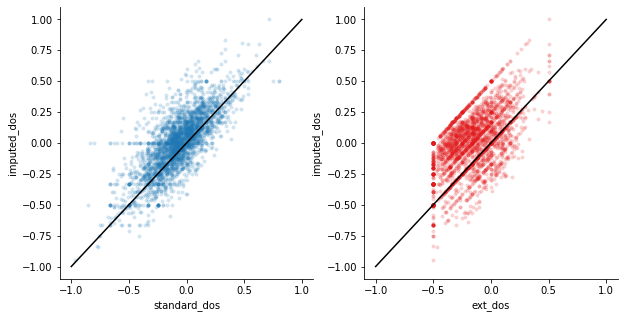

In [63]:
### Check correlation between standard, extended, and imputed DoS
df_mkt = pd.DataFrame.from_dict(mk_dict, orient='index')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1, ax2 = axes[0], axes[1]
p = sns.color_palette('Paired')
pal = p[1], p[5]

not_na_df = df_mkt[(df_mkt['ext_dos'] != 'NA') &
                   (df_mkt['imp_dos'] != 'NA')]

sns.scatterplot(ax=ax1, data=not_na_df, x='standard_dos', y='imp_dos',
                linewidth=0, s=15, color=pal[0], alpha=0.2)
sns.scatterplot(ax=ax2, data=not_na_df, x='ext_dos', y='imp_dos',
                linewidth=0, s=15, color=pal[1], alpha=0.2)

sns.lineplot(ax=ax1, x=[-1, 1], y=[-1, 1], color='black', dashes=True)
sns.lineplot(ax=ax2, x=[-1, 1], y=[-1, 1], color='black', dashes=True)
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)